In [5]:
import os                   # to interact with the operating system
import glob

import numpy as np
import pandas as pd
import xarray as xr

import pop_tools

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cartopy.feature as cfeature

import cmocean.cm as cmo
import matplotlib.ticker as ticker


ccrs = cartopy.crs

nature_coast = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',linewidth=0.5, edgecolor='black', facecolor='darkgray')

# Plot composite pressure anomaly

In [2]:
psl_file = os.path.expanduser('~/phase1_CONDA/')+'/results/composites/psl_anomaly.nc'
ds_psl = xr.open_dataset(psl_file)

plotting_data = ds_psl.PSL

In [3]:
vmin = -abs(ds_psl.PSL.max())
vmax = -vmin

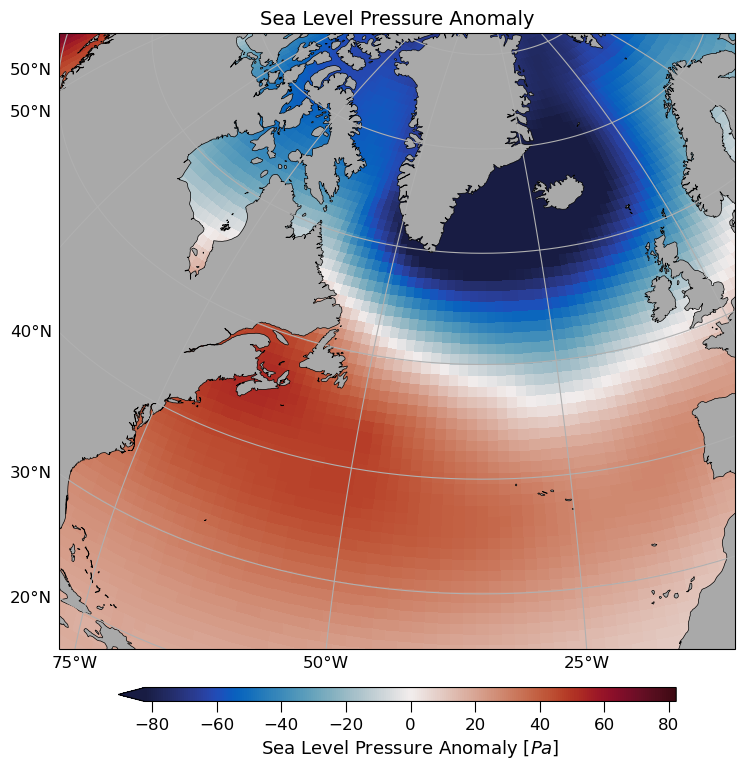

In [6]:
cbar_kwargs = {'orientation':'horizontal', 'shrink':0.8, 'aspect':40, 
               'label':r'Sea Level Pressure Anomaly [$Pa$]', 'pad': 0.05}

plt.figure(figsize=(9,10));
ax = plt.axes(projection=ccrs.Orthographic(central_latitude=40, central_longitude=-35))
ax.set_extent([-80,-10, 25, 80], crs=ccrs.PlateCarree())

pc = plotting_data.plot.pcolormesh(ax=ax, 
                                    transform=ccrs.PlateCarree(),
                                    x='lon', 
                                    y='lat',
                                    cbar_kwargs=cbar_kwargs,
                                    cmap=cmo.balance,
                                    vmin = vmin, vmax = vmax, 
                                    )
pc.colorbar.ax.xaxis.label.set_size(13)
pc.colorbar.ax.tick_params(axis='x', labelsize=12, size=8)
ax.tick_params(axis='both', which='both', labelsize=12, size=6)


gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

ax.add_feature(nature_coast);
plt.title('Sea Level Pressure Anomaly', fontsize=14)
plt.show()

# Compute first EOF of composite time series

- which area am interested in? --> North Atlantic sector (20°-70°N, 90°W-40°E) by Hurrell et al. 2003
- how do i get this stupid are with now again a different grid and the stupid 0 line exactly in my area

In [72]:
psl_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/PSLcomposite.nc'
ds_psl = xr.open_dataset(psl_file)

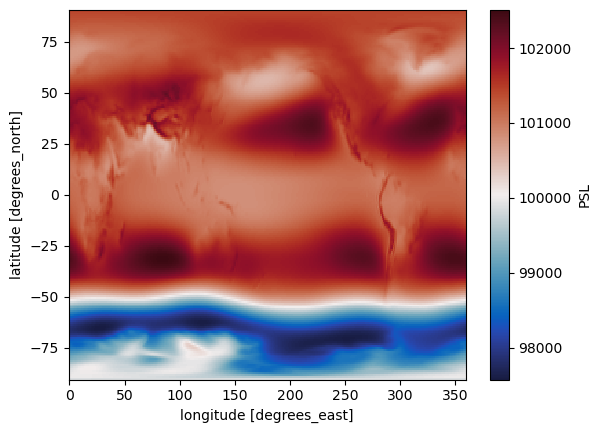

In [74]:
ds_psl.PSL.isel(time=0).plot(cmap=cmo.balance)

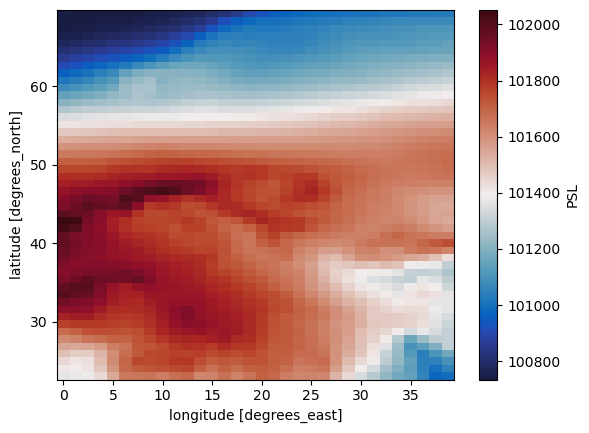

In [80]:
east_ds = ds_psl.isel(lat=slice(120,170), lon=slice(0, 32))
east_ds.PSL.isel(time=0).plot(cmap=cmo.balance)

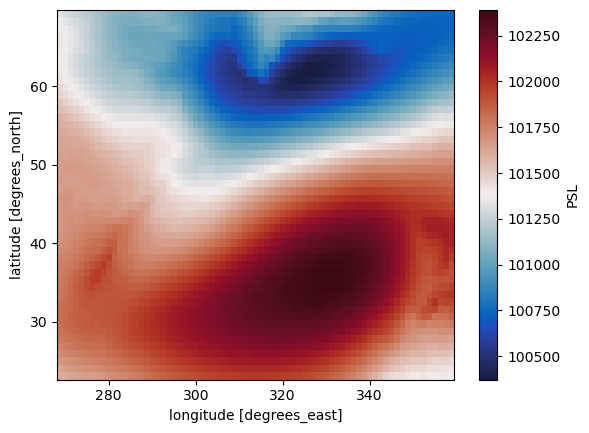

In [81]:
west_ds = ds_psl.isel(lat=slice(120,170), lon=slice(215, 288))
west_ds.PSL.isel(time=0).plot(cmap=cmo.balance)

In [68]:
print('40deg East', 360+40)
print('90deg West', 360-90)
print('')
print('east range: 0-32 - ', 288+32-80)
print('west range: 215-288', 215-80)

40deg East 400
90deg West 270

east range: 0-32 -  240
west range: 215-288 135


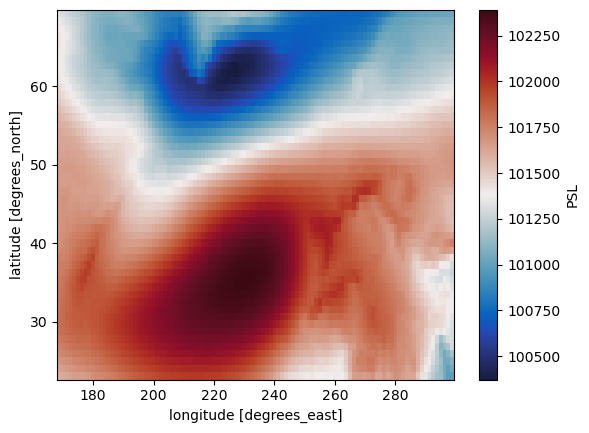

In [82]:
reduced_ds = ds_psl.roll(lon=-80).isel(lat=slice(120,170), lon=slice(135, 240))
reduced_ds.PSL.isel(time=0).plot(cmap=cmo.balance)

## Now figure out the weights

In [85]:
parameter_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/psl/psl_1231.001.nc'
ps_ds = xr.open_dataset(parameter_file)
ps_ds

<xarray.Dataset>
Dimensions:       (lat: 192, zlon: 1, nbnd: 2, lon: 288, lev: 32, ilev: 33,
                   time: 3012)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * zlon          (zlon) float64 0.0
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 1850-02-01 00:00:00 ... 2101-01-01 00:00:00
Dimensions without coordinates: nbnd
Data variables: (12/27)
    zlon_bnds     (zlon, nbnd) float64 ...
    gw            (lat) float64 ...
    hyam          (lev) float64 ...
    hybm          (lev) float64 ...
    P0            float64 ...
    hyai          (ilev) float64 ...
    ...            ...
    n2ovmr        (time) float64 ...
    f11vmr        (time) float64 ...
    f12vmr        (time) float64 ...
    sol_tsi       (time) float64 ...
    nsteph        (time) float64 ...
    PSL           (time, lat, lon) float32 ...
Attributes:
    Conventions:               CF-1.0
    source:                    CAM
    case:                      b.e21.BHISTcmip6.f09_g17.LE2-1231.001
    logname:                   sunseon
    host:                      mom1
    initial_file:              b.e21.B1850.f09_g17.CMIP6-piControl.001.cam.i....
    topography_file:           /mnt/lustre/share/CESM/cesm_input/atm/cam/topo...
    model_doi_url:             https://doi.org/10.5065/D67H1H0V
    time_period_freq:          month_1
    history:                   Tue Jan 30 10:59:33 2024: ncrcat --no_tmp_fl /...
    NCO:                       netCDF Operators version 4.7.4 (http://nco.sf....
    nco_openmp_thread_number:  1

In [119]:
def EOF(data, weights):
    
    weights = weights[np.newaxis, :,  np.newaxis]

    # Apply spatial weighting
    weighted_data = data * weights
    shape = weighted_data.shape
    # Reshape your data into a 2D array (time, space)
    data_2d = weighted_data.reshape(shape[0], -1)
    # Calculate the mean per time step along the time axis (axis=0)
    mean_per_time_step = np.nanmean(data_2d, axis=1)
    # Find NaNs in your data
    nan_indices = np.isnan(data_2d)
    # Replace NaNs with the mean of the corresponding time step
    data_2d[nan_indices] = np.take(mean_per_time_step, np.where(nan_indices)[0])
    # Calculate the mean along the time axis
    mean = np.mean(data_2d, axis=0)
    # Subtract the mean to center the data
    centered_data = data_2d - mean
    # Calculate the covariance matrix
    cov_matrix = np.cov(centered_data, rowvar=False)
    # Perform eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # EOF 1 time series 
    principal_components = eigenvectors[:, 0:1]
    # Project the data onto the principal components
    projected_data = centered_data.dot(principal_components)
    # Reconstruct the data from the principal component:
    reconstructed_data = (projected_data.dot(principal_components.T) + mean)
    reconstructed_data[nan_indices] = np.nan
    # Reshape the reconstructed data to the original shape
    original_shape_data = reconstructed_data.reshape(shape)
    original_shape_data = original_shape_data /weights
    
    eof1 = np.nanmax(original_shape_data, axis=(1,2))

    return principal_components, original_shape_data, eof1

In [109]:
print(reduced_ds.PSL.values.shape)
print(ps_ds.gw.isel(lat=slice(120,170)).values.shape)
reshaped_weights = weights[np.newaxis, :,  np.newaxis]
print(reshaped_weights.shape)

(3, 50, 105)
(50,)
(1, 50, 1)


In [122]:
data = reduced_ds.PSL.values
weights = ps_ds.gw.isel(lat=slice(120,170)).values

In [123]:
principal_components, original_shape_data, eof1 = EOF(data, weights)

In [124]:
print(principal_components.shape)
print(original_shape_data.shape)

(5250, 1)
(60, 50, 105)


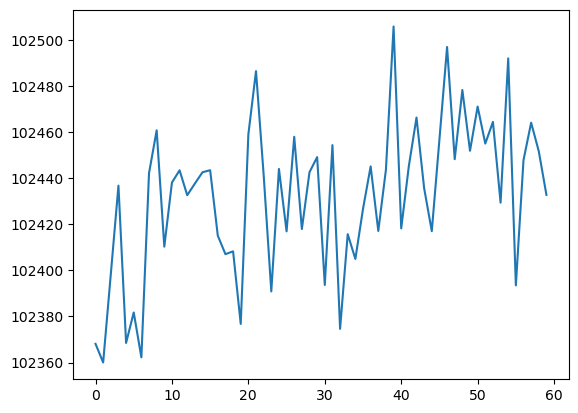

In [125]:
plt.plot(eof1)

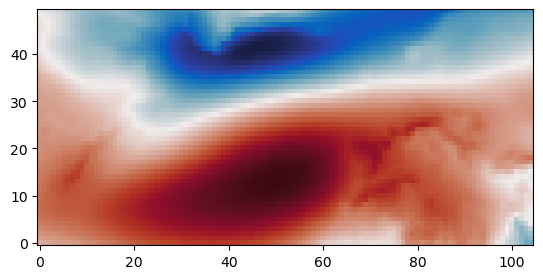

In [126]:
plt.imshow(original_shape_data[0,:,:], origin='lower', cmap=cmo.balance)

In [129]:
mean_along_axis_0 = np.mean(original_shape_data, axis=0)

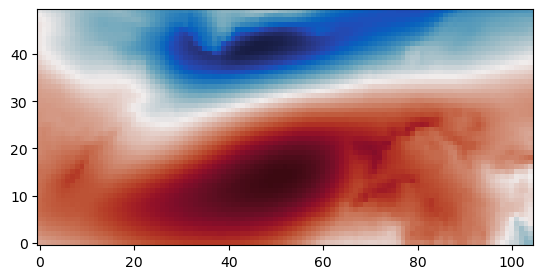

In [130]:
plt.imshow(mean_along_axis_0, origin='lower', cmap=cmo.balance)

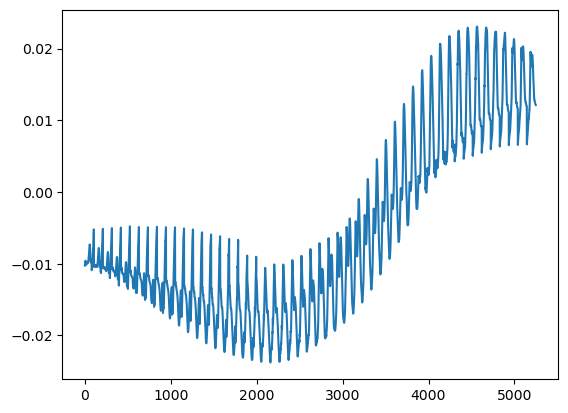

In [131]:
plt.plot(principal_components)